In [2]:
import sys
sys.path.append("../..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from scipy.stats import boxcox, pearsonr
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
# import statsmodels.regression.linear_model.OLS as OLS
# from modeldb.sklearn_native import CrossValidationScore
from sklearn.model_selection import GridSearchCV
import traceback
import math

from sklearn.model_selection import cross_val_score
from coh_tools import *
%matplotlib inline

style.use("ggplot")

In [5]:
# Get experiment info
os.chdir("/home/julien/school/lab/opto_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pd.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]


In [6]:
experiments

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0    Experiment1  MonkeyG  20150908  Session2     M1   
1    Experiment2  MonkeyG  20150908  Session3     M1   
2    Experiment3  MonkeyG  20150908  Session4     M1   
3    Experiment4  MonkeyG  20150909  Session2     M1   
4    Experiment5  MonkeyG  20150909  Session3     M1   
..           ...      ...       ...       ...    ...   
64  Experiment65  MonkeyJ  20160627  Session2     S1   
65  Experiment66  MonkeyJ  20160630  Session1     S1   
66  Experiment67  MonkeyJ  20160630  Session3     S1   
67  Experiment68  MonkeyJ  20160702  Session2     S1   
68  Experiment69  MonkeyJ  20160702  Session4     S1   

                           File Name  stim_Coh_from  stim_Coh_to  \
0   MonkeyG_20150908_Session2_M1.zip             46           63   
1   MonkeyG_20150908_Session3_M1.zip             48           43   
2   MonkeyG_20150908_Session4_M1.zip             48           16   
3   MonkeyG_20150909_Session2_M1.zip             48           12   
4   MonkeyG_20150909_Session3_M1.zip             53           27   
..                               ...            ...          ...   
64  MonkeyJ_20160627_Session2_S1.zip             39           14   
65  MonkeyJ_20160630_Session1_S1.zip             62           55   
66  MonkeyJ_20160630_Session3_S1.zip             58           63   
67  MonkeyJ_20160702_Session2_S1.zip             50           37   
68  MonkeyJ_20160702_Session4_S1.zip             44           64   

    Number of Lasers in Experiment  Number of Lasers during Conditioning  \
0                                2                                     2   
1                                2                                     2   
2                                2                                     2   
3                                2                                     2   
4                                2                                     2   
..                             ...                                   ...   
64                               2                                     2   
65                               2                                     2   
66                               2                                     2   
67                               2                                     2   
68                               2                                     2   

    Delay                       keyname   one   two  doubles  singles  
0    10ms  MonkeyG_20150908_Session2_M1  True  True     True    False  
1    10ms  MonkeyG_20150908_Session3_M1  True  True     True    False  
2    10ms  MonkeyG_20150908_Session4_M1  True  True     True    False  
3    10ms  MonkeyG_20150909_Session2_M1  True  True     True    False  
4    10ms  MonkeyG_20150909_Session3_M1  True  True     True    False  
..    ...                           ...   ...   ...      ...      ...  
64  100ms  MonkeyJ_20160627_Session2_S1  True  True     True    False  
65  100ms  MonkeyJ_20160630_Session1_S1  True  True     True    False  
66   10ms  MonkeyJ_20160630_Session3_S1  True  True     True    False  
67   10ms  MonkeyJ_20160702_Session2_S1  True  True     True    False  
68  100ms  MonkeyJ_20160702_Session4_S1  True  True     True    False  

[69 rows x 16 columns]

## Regression analysis

In [7]:
multiband_allcon_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_allcon_phase_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_phase_dict.pkl", "rb"))

# multiband_allcon_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_dict.pkl", "rb"))
# multiband_allcon_phase_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_phase_dict.pkl", "rb"))


In [8]:
multiband_allcon_dict.keys()

dict_keys(['theta', 'beta', 'gamma', 'high_gamma'])

In [9]:
ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = "/home/julien/school/lab/opto_data_analysis/csvs/")
# ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = r"C:\Users\julienb\lab\oe_data_analysis\csvs/")

def get_distance(electrode_a, electrode_b): # Indexing is 1 - 96
    if min(electrode_a, electrode_b) <= 0:
#         print("Electrode indexing starts from 1")
#         return
        return 0
    return ((ecog_map[0][electrode_a-1]  - ecog_map[0][electrode_b-1])**2 + (ecog_map[1][electrode_a-1]  - ecog_map[1][electrode_b-1])**2)**.5

# Flattens same way as np flatten()
def get_distances_multi(electrode_list_a, electrode_list_b=[]):
    electrode_list_b = np.array(electrode_list_b).astype(int)
    electrode_list_a = np.array(electrode_list_a).astype(int)
    if not electrode_list_b.any():
        electrode_list_b = electrode_list_a
    distances = []
    for electrode_a in electrode_list_a:
        for electrode_b in electrode_list_b:
            distances.append(get_distance(electrode_a, electrode_b))
    return distances
    # still need to implement unflattened

    def concatenator(lists):
        new_lists = []
        for list_ind in lists:
            new_lists.append(np.asarray(np.concatenate(list_ind)).flatten())
        return new_lists

In [10]:
good_channels = pkl.load(open("/home/julien/school/lab/opto_data_analysis/pickled/good_channels.pkl", "rb"))
# good_channels = pkl.load(open(r"C:\Users\julienb\lab\oe_data_analysis\pickled\good_channels.pkl", "rb"))

In [11]:
m1_data = pd.read_csv('M1_sites.csv')
s1_data = pd.read_csv('S1_sites.csv')

In [33]:
def polytransform_corrs(X, Y, pols=np.arange(-3, 3, .5)):
#     X = sm.add_constant(np.array(X))
    if min(X) <= 0:
        X += - min(X) + +.00001
#         X += +.00001
        print("X is neg, transforming")
        print(min(X))

    corrs = []
    ps = []
    for pol in pols:
        [corr, p] = pearsonr(boxcox(X, lmbda=pol), Y)
        corrs.append(corr)
        ps.append(p)
    return corrs #[corrs, ps]

## Bulk analyze all blocks of recordings

In [20]:
## Generate dataframe
## Do Stats ##
dataframes = {}
for band in ["theta", "beta", "gamma", "high_gamma"]:
# for band in ["theta"]:

    print(band)

    data_dict = multiband_allcon_dict[band]
    phase_dict = multiband_allcon_phase_dict[band]

    phasemeans = []
    condmeans = []
    basemeans = []
    newbasemeans = []
    delays = []
    deltacohs = []
    distances = []
    num_lasers = []
    coherence_projections = []
    block_nums = []
    distances_to_a1 = []
    distances_to_b1 = []
    distances_to_a2 = []
    distances_to_b2 = []
    experiment_block_keys = []
    pc1a = []
    pc2a = []
    pc1b = []
    pc2b = []
    monkeys = []
    both_m1 = []
    both_s1 = []
    
    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if (exp_num_laser == 0 or (row["stim_Coh_from"] == 0 and row["stim_Coh_to"] == 0)):
#             print(key)
            continue

        exp_good_channels = good_channels[key[:-3]]
        distancelist = get_distances_multi(exp_good_channels)

        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
        distance_to_a1_list = get_distances_multi(exp_good_channels, a_list)
        distance_to_b1_list = get_distances_multi(exp_good_channels, b_list)
        distance_to_a2_list = get_distances_multi(a_list, exp_good_channels)
        distance_to_b2_list = get_distances_multi(b_list, exp_good_channels)
        monkey_list = [key[6]]*len(distancelist)
        exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser
        m1_exp_data, s1_exp_data = get_m1_s1_matrices(m1_data, s1_data, good_channels, key[:-3])

        try:
            exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
        except:
#                     print("yeet")
            exp_delay_list = np.zeros(len(distancelist))

        for block_num in np.arange(6)+1:                                        
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            if block_num < 6:
                block_base_data = data_dict[rec_key].mean(0)
                basemeans.append(block_base_data.flatten())
                phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                condmeans.append(data_dict[stim_key].mean(0).flatten())
                coherence_projections.append(np.dot(block_base_data, block_base_data).flatten())
                distances.append(distancelist)
                distances_to_a1.append(distance_to_a1_list)
                distances_to_b1.append(distance_to_b1_list)
                distances_to_a2.append(distance_to_a2_list)
                distances_to_b2.append(distance_to_b2_list)
                num_lasers.append(exp_num_laser_list)
                delays.append(exp_delay_list)
                block_nums.append(block_num*np.ones(len(distancelist)))
                experiment_block_keys.append([stim_key[:-14]]*len(distancelist))
                both_m1.append(m1_exp_data.flatten())
                both_s1.append(s1_exp_data.flatten())

                if block_num == 1:
                    scaler = StandardScaler()
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)
                ## Need to fix this PCA stuff so I have one for each electrode
                pca_data = pca.transform(scaler.transform(block_base_data))
                pc1a.append(np.repeat(pca_data[:, 0], pca_data.shape[0]))
                pc2a.append(np.repeat(pca_data[:, 1], pca_data.shape[0]))
                pc1b.append(np.tile(pca_data[:, 0], pca_data.shape[0]))
                pc2b.append(np.tile(pca_data[:, 1], pca_data.shape[0]))
#                 experiment_keys.append([key]*)
                monkeys.append(monkey_list)

                
            if block_num > 1:
                newbasemeans.append(data_dict[rec_key].mean(0).flatten())

#     lists_to_concat = [phasemeans, distances, distances_to_a1, distances_to_b1, distances_to_a2
#                       distances_to_b2, basemeans, newbasemeans, condmeans, num_lasers,
#                       coherence_projections, delays, block_nums, pc1a, pc2a, pc1b, pc2b]
#     for list_i in lists_to_concat:
#         lists_to_concat[list_i] = np.asarray(np.concatenate(lists_to_concat[list_i])).flatten()
    phasemeans = np.asarray(np.concatenate(phasemeans)).flatten()
    distances = np.asarray(np.concatenate(distances)).flatten()
    distances_to_a1 = np.asarray(np.concatenate(distances_to_a1)).flatten()
    distances_to_b1 = np.asarray(np.concatenate(distances_to_b1)).flatten()
    distances_to_a2 = np.asarray(np.concatenate(distances_to_a2)).flatten()
    distances_to_b2 = np.asarray(np.concatenate(distances_to_b2)).flatten()
    basemeans = np.asarray(np.concatenate(basemeans)).flatten()
    newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
    condmeans = np.asarray(np.concatenate(condmeans)).flatten()
    num_lasers = np.asarray(np.concatenate(num_lasers)).flatten()
    coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
    delays = np.asarray(np.concatenate(delays)).flatten()
    block_nums = np.asarray(np.concatenate(block_nums)).flatten()
    pc1a = np.asarray(np.concatenate(pc1a)).flatten()
    pc2a = np.asarray(np.concatenate(pc2a)).flatten()
    pc1b = np.asarray(np.concatenate(pc1b)).flatten()
    pc2b = np.asarray(np.concatenate(pc2b)).flatten()
    monkeys = np.asarray(np.concatenate(monkeys)).flatten()
    experiment_block_keys = np.asarray(np.concatenate(experiment_block_keys)).flatten()
    both_m1 = np.asarray(np.concatenate(both_m1)).flatten()
    both_s1 = np.asarray(np.concatenate(both_s1)).flatten()

    cond_diff_Y = condmeans - basemeans
    cond_diff_percent_Y = (condmeans - basemeans)/basemeans
    diff_Y = newbasemeans - basemeans
    diff_percent_Y = (newbasemeans - basemeans)/basemeans

    data_scaled = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
                        "Coh_proj": coherence_projections, "Phase": phasemeans,
                        "Distance_to_A1": distances_to_a1, "Distance_to_B1": distances_to_b1,
                        "Distance_to_A2": distances_to_a2, "Distance_to_B2": distances_to_b2,
                        "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b})
#     scaler = StandardScaler()
#     data_scaled = data #pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
    data_scaled["Num_lasers"] = num_lasers
    data_scaled["Delays"] = delays
    data_scaled["Distance_to_A1"] = distances_to_a1
    data_scaled["Distance_to_B1"] = distances_to_b1
    data_scaled["Distance_to_A2"] = distances_to_a2
    data_scaled["Distance_to_B2"] = distances_to_b2
#     data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled), columns = data.columns)
    data_scaled["Monkeys"] = monkeys
    data_scaled["Block_num"] = block_nums
    data_scaled["Experiment_block_key"] = experiment_block_keys
    data_scaled["Both_M1"] = both_m1
    data_scaled["Both_S1"] = both_s1

    data_scaled["cond_diff_Y"] = cond_diff_Y  
    data_scaled["cond_diff_percent_Y"] = cond_diff_percent_Y
    data_scaled["diff_Y"] = diff_Y
    data_scaled["diff_percent_Y"] = diff_percent_Y
        
    dataframes[band] = data_scaled # .drop_duplicates(data_scaled.columns.drop(["From_electrodes", "To_electrodes"]))
    
#     del(data)
    del(data_scaled)
#     break

    
    

theta
beta
gamma
high_gamma


In [21]:
dataframes[band].columns

Index(['Initial_coh', 'Distance', 'Coh_proj', 'Phase', 'Distance_to_A1',
       'Distance_to_B1', 'Distance_to_A2', 'Distance_to_B2', 'PC1a', 'PC2a',
       'PC1b', 'PC2b', 'Num_lasers', 'Delays', 'Monkeys', 'Block_num',
       'Experiment_block_key', 'Both_M1', 'Both_S1', 'cond_diff_Y',
       'cond_diff_percent_Y', 'diff_Y', 'diff_percent_Y'],
      dtype='object')

X is neg, transforming
1e-05
X is neg, transforming
9.99999999995449e-06


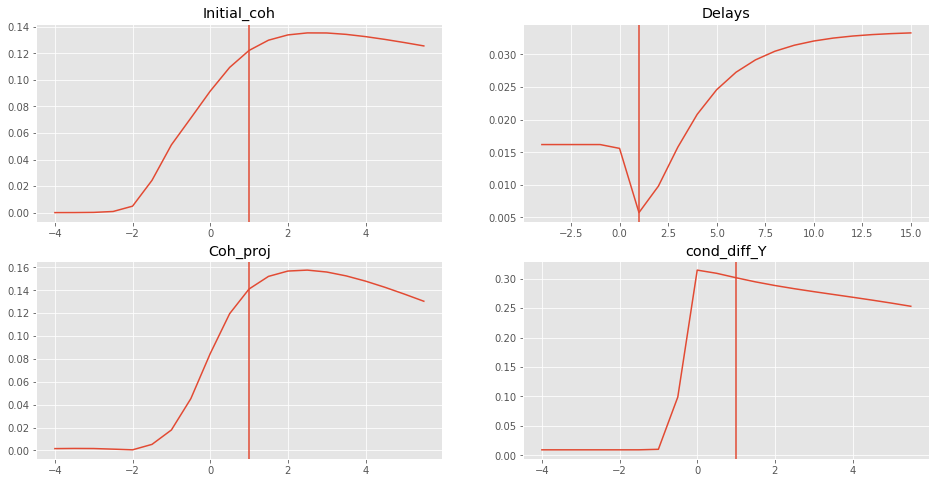


X is neg, transforming
1e-05
X is neg, transforming
9.99999999995449e-06


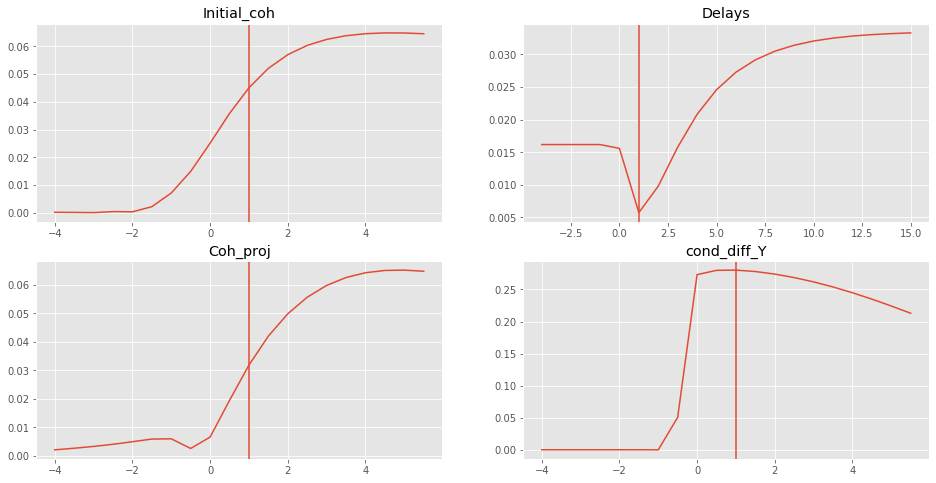


X is neg, transforming
1e-05
X is neg, transforming
9.99999999995449e-06


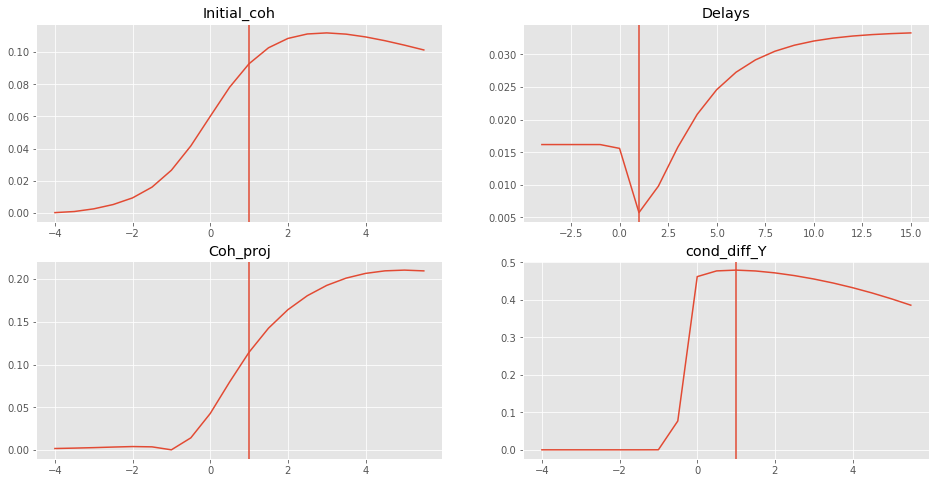


X is neg, transforming
1e-05
X is neg, transforming
9.99999999995449e-06


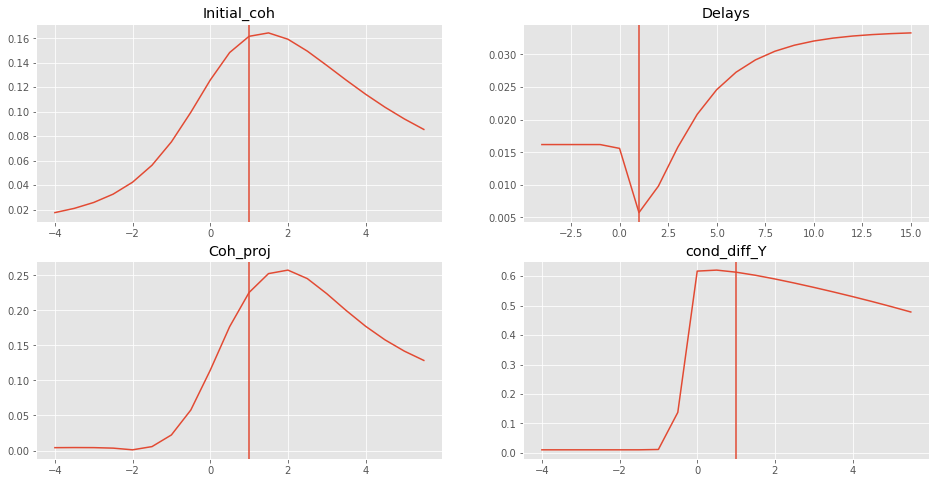

In [34]:
for band in ["theta", "beta", "gamma", "high_gamma"]:

    tau = 10
    delay_curve = np.exp(-np.array(delays)/tau)

#     titles = dataframes[band]["Distance", "Delays", "coherence_projections", "phasemeans"]
    features_to_transform = ["Initial_coh", "Delays", "Coh_proj", "cond_diff_Y"]
    fig, axs = plt.subplots(2, 2, figsize=[16, 8])
    for feat_i, feature in enumerate(features_to_transform):
        poly_t = np.arange(-4, 6, .5)
        if feat_i == 1:
            poly_t = np.arange(-4, 16, 1)
        dist_corrs = np.abs(polytransform_corrs(dataframes[band][feature], diff_Y, poly_t))
    #         plt.subplots(2, 2, num=feat_i)
        axs[feat_i//2, feat_i%2].plot(poly_t, dist_corrs)
        axs[feat_i//2, feat_i%2].axvline(1)
        axs[feat_i//2, feat_i%2].set_title(features_to_transform[feat_i], color="black")
    plt.show()

    print()

(array([1285314.,  181226.,  129661.,  108467.,   98791.,   73700.,
          38041.,   19367.,    9669.,    4609.]),
 array([4.51928665e-02, 7.11895863e+02, 1.42374653e+03, 2.13559720e+03,
        2.84744787e+03, 3.55929854e+03, 4.27114921e+03, 4.98299988e+03,
        5.69485055e+03, 6.40670122e+03, 7.11855189e+03]),
 <a list of 10 Patch objects>)

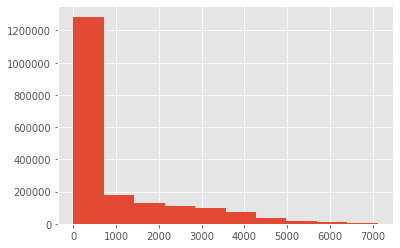

In [40]:
plt.hist(dataframes["theta"]["Coh_proj"]**2)

In [82]:
import statsmodels.graphics.api as smg

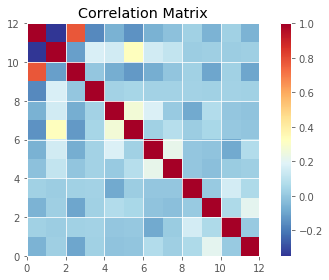

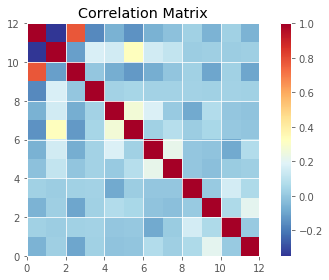

In [88]:
corr_matrix = np.corrcoef(data.T)
smg.plot_corr(corr_matrix)

In [46]:
# sns.pairplot(data_scaled.iloc[range(0, 1948845, 7777)], diag_kind = 'kde', kind='reg',
#              size = 4)

In [32]:
data.shape[0]

1948845

## Analyze sessions individually

In [ ]:
## Do Stats ##
rsquareds = {band: [] for band in ["theta", "beta", "gamma", "high_gamma"]}
params = {band: [] for band in ["theta", "beta", "gamma", "high_gamma"]}
for band in ["theta", "beta", "gamma", "high_gamma"]:
# for band in ["beta"]:

    print(band)

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if exp_num_laser == 0:
            continue

        try:
            data_dict = multiband_allcon_dict[band]
            phase_dict = multiband_allcon_phase_dict[band]

            phasemeans = []
            condmeans = []
            basemeans = []
            newbasemeans = []
            delays = []
            deltacohs = []
            distances = []
            num_lasers = []
            coherence_projections = []
            pc1a = []
            pc2a = []
            pc1b = []
            pc2b = []
            block_nums = []


            exp_good_channels = good_channels[key[:-3]]    
            distancelist = get_distances_multi(exp_good_channels)
            a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
            b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
#                 distance_to_a_list = get_distances_multi(exp_good_channels, a_list)
#                 distance_to_b_list = get_distances_multi(exp_good_channels, b_list)
            exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser

            try:
                exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
            except:
#                     print("yeet")
                exp_delay_list = np.zeros(len(distancelist))

            for block_num in np.arange(6)+1:                                        
                rec_key = key+"_RecBlock"+str(block_num)
                stim_key = key+"_CondBlock"+str(block_num)
                if block_num < 6:
                    block_base_data = data_dict[rec_key].mean(0)
                    basemeans.append(block_base_data.flatten())
                    phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                    condmeans.append(data_dict[stim_key].mean(0).flatten())
                    coherence_projections.append(np.dot(block_base_data, block_base_data).flatten())
                    distances.append(distancelist)
#                         distances_to_a.append(distance_to_a_list)
#                         distances_to_b.append(distance_to_b_list)
                    num_lasers.append(exp_num_laser_list)
                    delays.append(exp_delay_list)
                    block_nums.append(block_num*np.ones(len(distancelist)))

                    if block_num == 1:
                        scaler = StandardScaler()
                        scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                        pca = PCA(n_components=2)
                        pca.fit(scaled_base)
                    ## Need to fix this PCA stuff so I have one for each electrode
                    pca_data = pca.transform(scaler.transform(block_base_data))
                    pc1a.append(np.repeat(pca_data[:, 0], pca_data.shape[0]))
                    pc2a.append(np.repeat(pca_data[:, 1], pca_data.shape[0]))
                    pc1b.append(np.tile(pca_data[:, 0], pca_data.shape[0]))
                    pc2b.append(np.tile(pca_data[:, 1], pca_data.shape[0]))

                if block_num > 1:
                    newbasemeans.append(data_dict[rec_key].mean(0).flatten())


            phasemeans = np.asarray(np.concatenate(phasemeans)).flatten()
            distances = np.asarray(np.concatenate(distances)).flatten()
    #         distances_to_a = np.asarray(np.concatenate(distances_to_a)).flatten()
    #         distances_to_b = np.asarray(np.concatenate(distances_to_b)).flatten()
            basemeans = np.asarray(np.concatenate(basemeans)).flatten()
            condmeans = np.asarray(np.concatenate(condmeans)).flatten()
            newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
            num_lasers = np.asarray(np.concatenate(num_lasers)).flatten()
            coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
            delays = np.asarray(np.concatenate(delays)).flatten()
            pc1a = np.asarray(np.concatenate(pc1a)).flatten()
            pc2a = np.asarray(np.concatenate(pc2a)).flatten()
            pc1b = np.asarray(np.concatenate(pc1b)).flatten()
            pc2b = np.asarray(np.concatenate(pc2b)).flatten()
            block_nums = np.asarray(np.concatenate(block_nums)).flatten()
            
            Y = (np.array(condmeans) - np.array(basemeans))/basemeans
    #         tau = 10
    #         delay_curve = np.exp(-np.array(delays)/tau)

            data = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
                                "Coh_proj": coherence_projections, "Phase": phasemeans,
                                "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b})
            scaler = StandardScaler()
            data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
            data_scaled["Num_lasers"] = num_lasers
            data_scaled["Y"] = Y
            data_scaled["Delays"] = delays

            ## Linear Models ##
#                 print(key)
            ols_nointeract = smf.ols(formula='Y ~ Initial_coh + Distance + Phase \
                           + Coh_proj + PC1a + PC2a + PC1b + PC2b + C(Delays)', data=data_scaled).fit()#_regularized(alpha=alpha, refit=True)
#                 print(ols_nointeract.rsquared)
#                 print()
            rsquareds[band].append(ols_nointeract.rsquared)
            params[band].append(ols_interact.params)

        except Exception as e:
#                 print(key)
            print(e)
#                 traceback.print_exc()
            continue

In [ ]:
rsquared_data = pd.DataFrame({"Theta": rsquareds["theta"], "Beta": rsquareds["beta"],
                "Gamma": rsquareds["gamma"], "High Gamma": rsquareds["high_gamma"]})
plt.figure(figsize=(8, 6))
sns.boxplot(data = rsquared_data)
plt.ylabel("R-Squared")
plt.title("Goodness of fit per band")

In [ ]:
abs(params['theta'][0])

In [ ]:
distances_to_a.shape

(array([1.925207e+06, 2.078400e+04, 2.132000e+03, 4.040000e+02,
        1.280000e+02, 1.100000e+02, 3.400000e+01, 2.800000e+01,
        1.000000e+01, 8.000000e+00]),
 array([-0.82241884,  0.78648772,  2.39539428,  4.00430084,  5.6132074 ,
         7.22211397,  8.83102053, 10.43992709, 12.04883365, 13.65774021,
        15.26664677]),
 <a list of 10 Patch objects>)

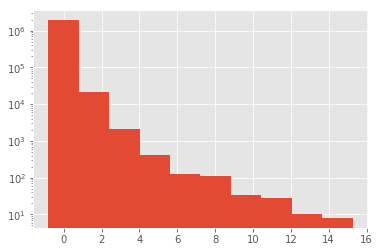

In [24]:
plt.hist(cond_diff_percent_Y, log=True)

(array([1.926921e+06, 1.925000e+04, 1.974000e+03, 3.820000e+02,
        1.300000e+02, 1.100000e+02, 3.000000e+01, 2.800000e+01,
        1.200000e+01, 8.000000e+00]),
 array([-0.89287574,  0.69639438,  2.2856645 ,  3.87493462,  5.46420474,
         7.05347486,  8.64274498, 10.2320151 , 11.82128522, 13.41055534,
        14.99982546]),
 <a list of 10 Patch objects>)

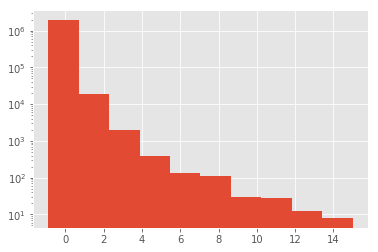

In [30]:
plt.hist(ols_percent.resid, log=True)

In [35]:
min(cond_diff_percent_Y)

-1.6448376821091397

([array([2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 1.000000e+01, 2.900000e+02, 6.800000e+03,
         1.930317e+06, 1.142600e+04]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])],
 array([-14.81895136, -13.09327197, -11.36759259,  -9.6419132 ,
         -7.91623382,  -6.19055443,  -4.46487505,  -2.73919567,
         -1.01351628,   0.7121631 ,   2.43784249]),
 <a list of 2 Lists of Patches objects>)

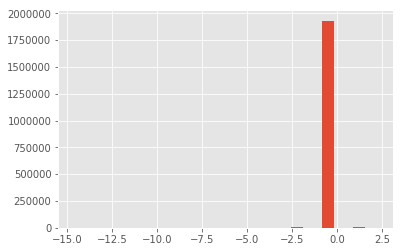

In [37]:
plt.hist(boxcox(cond_diff_percent_Y-min(cond_diff_percent_Y)+.0001))

In [43]:
boxcox(cond_diff_percent_Y-min(cond_diff_percent_Y)+.0001)[1:]

(-0.02663158811620386,)